In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preparation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_seq_items=8000
pd.options.display.max_rows = 8000

## Import the dataset

In [ ]:
# Loading the train set
train = pd.read_csv('/content/drive/MyDrive/energy_dataset/train.csv')
building = pd.read_csv('/content/drive/MyDrive/energy_dataset/building_metadata.csv')
weather_train = pd.read_csv('/content/drive/MyDrive/energy_dataset/weather_train.csv')


In [ ]:
# Loading test set
test_data = pd.read_csv('/content/drive/MyDrive/energy_dataset/test.csv') 
weather_test_data = pd.read_csv('/content/drive/MyDrive/energy_dataset/weather_test.csv') 

In [ ]:
# Shapes of the dataframes
print('Shape of train data:',train.shape)
print('Shape of weather train data:', weather_train.shape)
print('Shape of building meta data:', building.shape)
print('Shape of test data:', test.shape)
print('Shape of weather test data:', weather_test.shape)

Shape of train data: (20216100, 4)
Shape of weather train data: (139773, 9)
Shape of building meta data: (1449, 6)


In [ ]:
#https://www.kaggle.com/kernels/scriptcontent/3684066/download
# WE MAY USE THIS FUNCTION TO REDUCE MEMORY USEAGE

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    #iterating over every column and finding the type of the column
    for col in df.columns:
      if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
      col_type = df[col].dtype
        
        #If the columns is not object
      if col_type != object:
          #Get the minimum and maximum value
            c_min = df[col].min()
            c_max = df[col].max()
            #If the type is int
            if str(col_type)[:3] == 'int':
              #If the min max values lies with thin the range of int8 type then assign the type as int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
              #If the min max values lies with thin the range of int16 type then assign the type as int16 
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
              #If the min max values lies with thin the range of int32 type then assign the type as int32
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
              #If the min max values lies with thin the range of int64 type then assign the type as int64
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
              #If the min max values lies with thin the range of float16 type then assign the type as float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
              #If the min max values lies with thin the range of float32 type then assign the type as float32
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
      else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
# Memory reduce
train = reduce_mem_usage(train)
building = reduce_mem_usage(building)
weather_train=reduce_mem_usage(weather_train)

test = reduce_mem_usage(test)
weather_test = reduce_mem_usage(weather_test)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.84 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.9%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.59 MB
Decreased by 73.1%


In [ ]:
test_data = reduce_mem_usage(test_data, 'Test Data')
weather_test_data = reduce_mem_usage(weather_test_data, 'Weather Test Data')

## Combining the datasets

In [ ]:
#We will combine the all the data for train set in a single dataframe and test set in another dataframe
# Merging train set
train_df = train.merge(building, on='building_id', how='left')
train_df = train_df.merge(weather_train, on=['site_id', 'timestamp'], how='left')

In [ ]:
# Merging test set
test_df = test_data.merge(building, on='building_id', how='left')
test_df = test_df.merge(weather_test_data, on=['site_id', 'timestamp'], how='left')

## Correct the unit

In [ ]:
# the electric meter readings for site 0 were not properly converted to units of kWh and are in kBTU (over 900k rows)
# Multiply by 0.2931 to get to model inputs into kWh like the other sites, and 3.4118 to get back to kBTU for scoring.
# DO NOT RUN THIS CELL TWICE!
train_df.loc[(train_df['site_id'] == 0) & (train_df['meter'] == 0), 'meter_reading'] = train_df[(train_df['site_id'] == 0) & (train_df['meter'] == 0)]['meter_reading'] * 0.2931

## Break the datatime into day, month

In [ ]:
# We will break the timestamp into hour of the day, day of week, month and the year.
# Maybe the timestamp column should be drop during training stage.

def break_datetime(df):
  df['timestamp']= pd.to_datetime(df['timestamp'])
  df['hour']= np.uint8(df['timestamp'].dt.hour)
  df['dayofweek']= np.uint8(df['timestamp'].dt.dayofweek)
  df['month']= np.uint8(df['timestamp'].dt.month)
  df['dayofyear']= np.uint16(df['timestamp'].dt.dayofyear)
  df['day']= np.uint16(df['timestamp'].dt.day) #day of month
  df['year']= np.uint16(df['timestamp'].dt.year)
  return df

In [ ]:
train_df = break_datetime(train_df)

In [ ]:
test_df = break_datetime(test_df)

In [ ]:
train_df.head(5)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016


# T1 - Descriptive analysis of the dataset (base on the train data)

In [ ]:
print('\nInformation of the dataset...... \n')
print(train_df.info())
print('\nStatistically infomation of the dataset......\n', train_df.describe())


Information of the dataset...... 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 22 columns):
 #   Column              Dtype   
---  ------              -----   
 0   building_id         int16   
 1   meter               int8    
 2   timestamp           category
 3   meter_reading       float32 
 4   site_id             int8    
 5   primary_use         category
 6   square_feet         int32   
 7   year_built          float16 
 8   floor_count         float16 
 9   air_temperature     float16 
 10  cloud_coverage      float16 
 11  dew_temperature     float16 
 12  precip_depth_1_hr   float16 
 13  sea_level_pressure  float16 
 14  wind_direction      float16 
 15  wind_speed          float16 
 16  hour                uint8   
 17  dayofweek           uint8   
 18  month               uint8   
 19  dayofyear           uint16  
 20  day                 uint16  
 21  year                uint16  
dtypes: category(2), float16(9), 

We can see many features' mean values are 'NaN'. It caused by null values.

## Check missing values

In [ ]:
#Check null values
train_df.isnull().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
hour                         0
dayofweek                    0
month                        0
dayofyear                    0
day                          0
year                         0
dtype: int64

In [ ]:
# missing_values percentage

missing_values = pd.DataFrame(train_df.isnull().sum() * 100 / len(train_df))
missing_values.columns = ["Missing Values"]

missing_values = missing_values[missing_values["Missing Values"] != 0]
missing_values.sort_values(by = "Missing Values", axis = 0, ascending = False, inplace = True)

missing_values

,Missing Values
floor_count,82.652772
year_built,59.990033
cloud_coverage,43.655131
precip_depth_1_hr,18.544739
wind_direction,7.167792
sea_level_pressure,6.092515
wind_speed,0.710701
dew_temperature,0.495348
air_temperature,0.478124


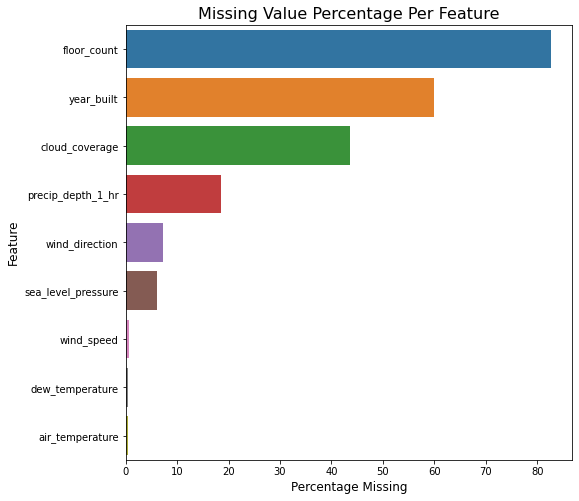

In [ ]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x = missing_values['Missing Values'], y = missing_values.index, )
ax.set_title("Missing Value Percentage Per Feature", fontsize=16)
plt.xlabel('Percentage Missing', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

many missing values. maybe imputate them during pre-processing stage.

## Check duplicates

In [ ]:
print(len(train_df[train_df.duplicated()]))

0


## Box plots

In [ ]:
box_features = ['meter_reading','square_feet','floor_count','air_temperature','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']

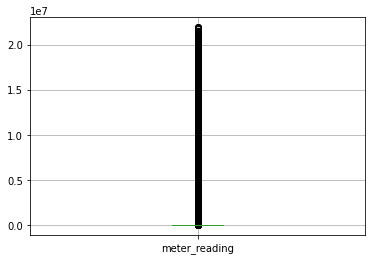

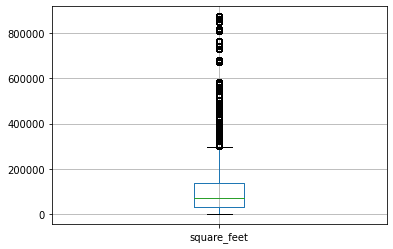

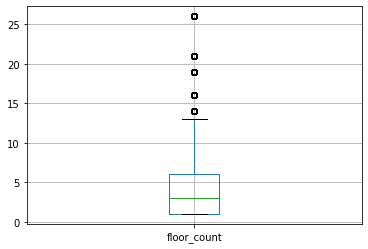

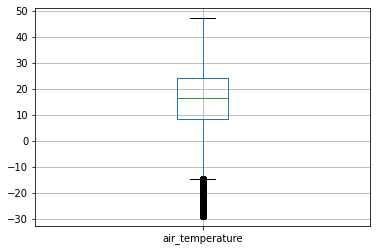

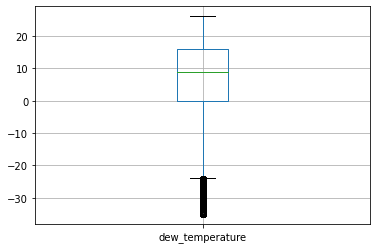

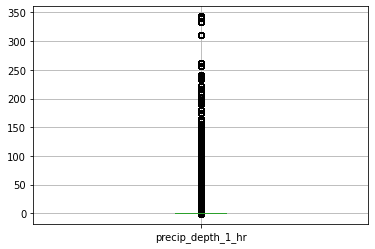

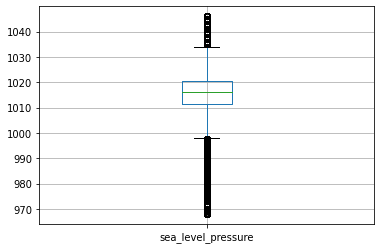

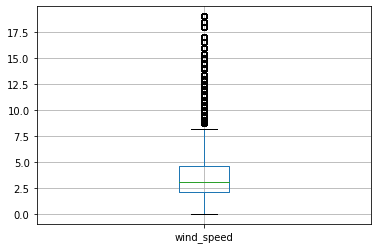

In [ ]:
for column in train_df[box_features]:
    plt.figure()
    train_df.boxplot([column])

There are many outiler in each feature. Esepically the meter_reading, we will look into it later.

## Main features' analysis

### Distribution overview

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f266cde24d0>,
      dtype=object)

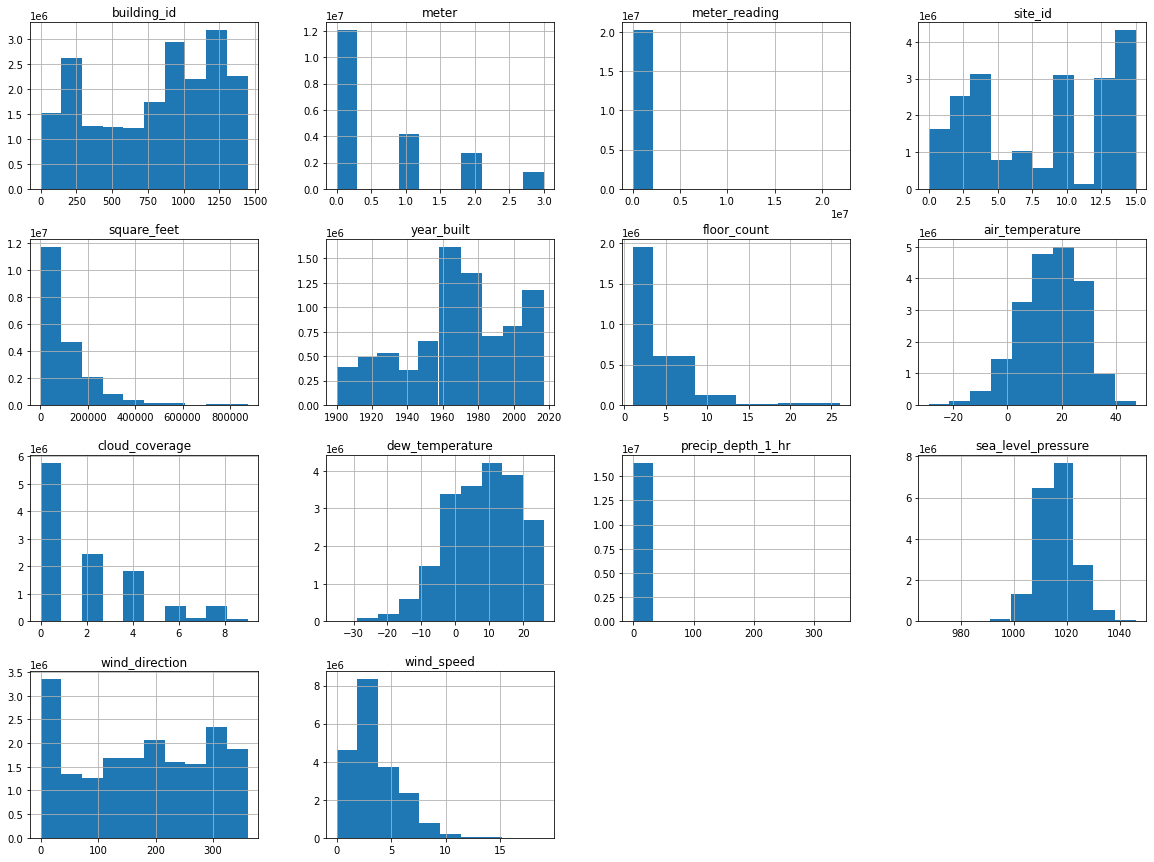

In [ ]:
train_df.iloc[:,0:-6].hist(figsize=(20,15))

### Meter reading

#### Distribuiton & Transformation

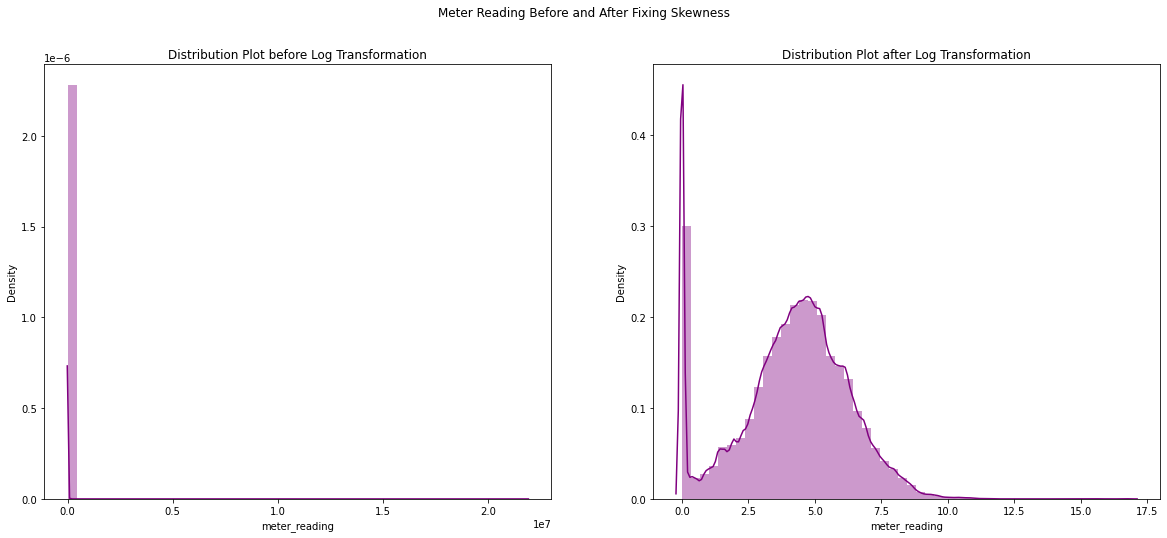

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Meter Reading Before and After Fixing Skewness')

sns.distplot(train_df['meter_reading'], color='purple', ax = ax1)
ax1.set_title('Distribution Plot before Log Transformation')

sns.distplot(np.log1p(train_df['meter_reading']), color='purple', ax = ax2)
ax2.set_title('Distribution Plot after Log Transformation')

plt.show()

As we can see from the left chart, our target variable (meter_reading) heavily skewed and not much of insights can be gathered from the above plot. Hence we fixed this issue by using log transformation (see right chart).
After the transformation we can see the most of meter reading lie between 0 and 10. The most of reading is zero, followed by 5.

In [ ]:
#Summary after transformations
train_df['meter_reading_log'] = np.log1p(train_df['meter_reading'])
train_df['meter_reading_log'].describe()

count    2.021610e+07
mean     4.164197e+00
std      2.071129e+00
min      0.000000e+00
25%      2.943170e+00
50%      4.331917e+00
75%      5.535758e+00
max      1.690221e+01
Name: meter_reading_log, dtype: float64

#### Average meter reading by hour, day and month

Hourly

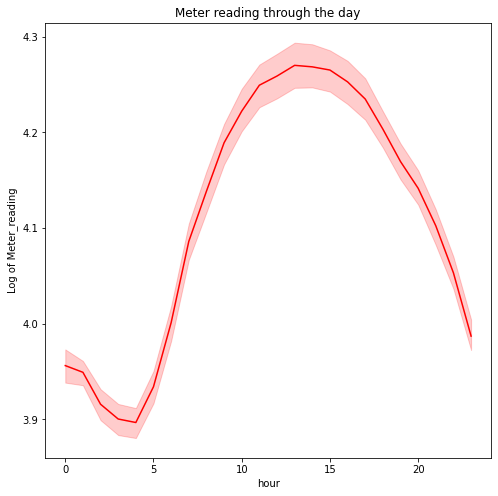

In [ ]:
plt.figure(figsize=(8,8))
hour_df= train_df.groupby(['timestamp','hour']).meter_reading_log.mean().reset_index() # every hours mean usage
sns.lineplot(x=hour_df['hour'], y=hour_df['meter_reading_log'], color='red')
plt.ylabel("Log of Meter_reading")
plt.title("Meter reading through the day")
plt.show()

It can be observerd from the above plot that the meter readings drop in the early hours of the morning around 4am and rises again after 6am. The hourly usage peaks in the afternoon arpund 3pm. This behaviour is obvious as most of institutes, industries and other buildings are fully operational during this time. And after 3pm the enerage usage start to decrease.

Daily

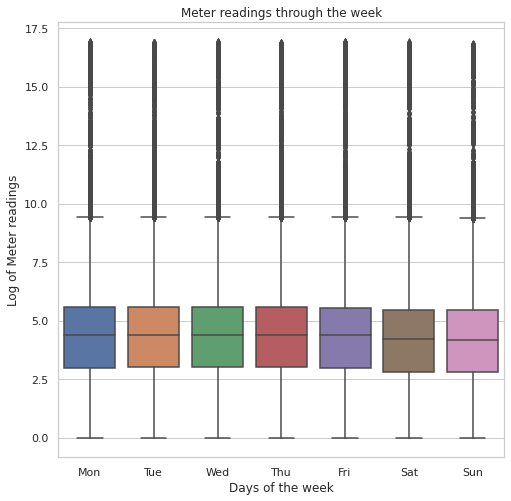

In [ ]:
#Lets check the day wise usage of power
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,8))
day_labels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
p=sns.boxplot(x=train_df['dayofweek'], y=train_df['meter_reading_log'])
p.set_xticklabels(day_labels)
plt.xlabel("Days of the week")
plt.ylabel("Log of Meter readings")
plt.title("Meter readings through the week")
plt.show()

There is not much of a difference in day to day basis of usage. Still, weekends' usage has relatively lower than week days as we know most of the companies and educational institutions are closed on sunday. Besides, there are many outliers which used more energe than other.

Monthly

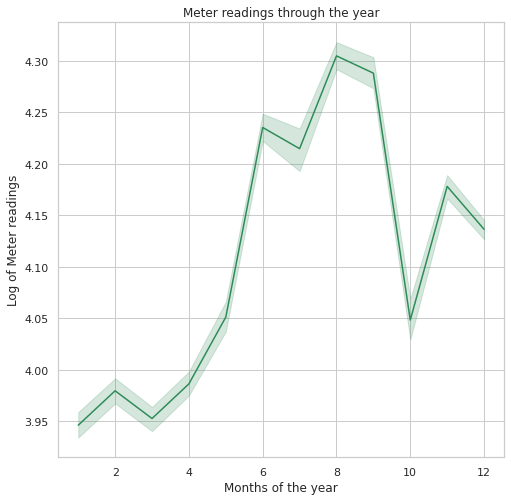

In [ ]:
#Lets check the month wise usage of power
plt.figure(figsize=(8,8))
month_df= train_df.groupby(['timestamp','month']).meter_reading_log.mean().reset_index()
sns.lineplot(x=month_df['month'], y=month_df['meter_reading_log'], color='seagreen')
plt.xlabel("Months of the year")
plt.ylabel("Log of Meter readings")
plt.title("Meter readings through the year")
plt.show()

The average monthly consumption is minimal in the initial months and then rises after April. It peaks in August and starts dropping.

### Primary use

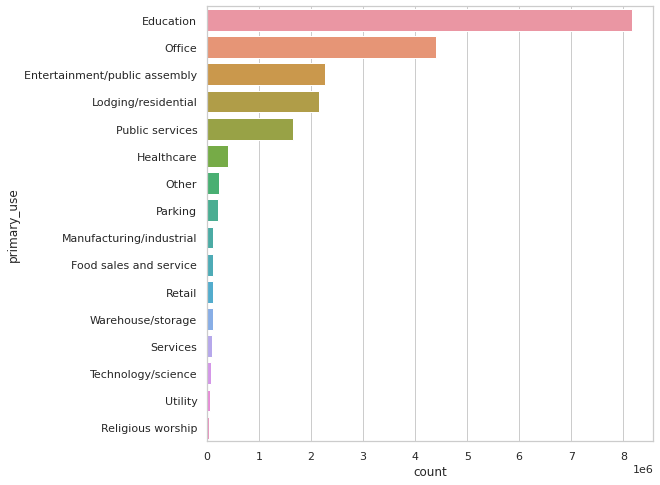

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='primary_use', data=train_df, order = train_df['primary_use'].value_counts().index)

**Most number of readings** are present for educational institutes followed by office, enetertainment and Lodging/residential buildings.

#### Average consumption by primary use

Hourly

In [ ]:
primary_use_df = train_df.groupby(['hour', 'primary_use']).meter_reading_log.mean().reset_index()

In [ ]:
px.line(primary_use_df, x="hour", y="meter_reading_log", color='primary_use', width=1000, height=600, title = 'Average hourly consumption by primary use')

Daily

In [ ]:
primary_use_df = train_df.groupby(['dayofweek', 'primary_use']).meter_reading_log.mean().reset_index()
px.line(primary_use_df, x="dayofweek", y="meter_reading_log", color='primary_use', width=900, height=600, title = 'Average daily  consumption by primary use')

In the above figure, we have plotted the average daily usage for each of the primary usage category. As we can see from the above plots, the average consumption is the lowest on sundays for all types of buildings except for food sales. It has the lowest consumption on saturdays.


**0 should be Monday (make sense)**

Monthly

In [ ]:
primary_use_df = train_df.groupby(['month', 'primary_use']).meter_reading_log.mean().reset_index()
px.line(primary_use_df, x="month", y="meter_reading_log", color='primary_use', width=1000, height=600, title = 'Average monthly consumption by primary use')

In the above figure, we have plotted the average hourly usage for each of the primary usage category.


*   The educational institutes have the peak usage in August and September. The usage is minimum in the initial months of the year.
*   The consumption for enetertainment buildings rises is minimum around March and maximum in August.
* There is a clear decreasing trend for manufacturing which hits the minimum in the july month and then starts rising again.

### Meter

In [ ]:
meter_types_labels = {'electricity':0, 'chilledwater':1, 'steam':2, 'hotwater':3}

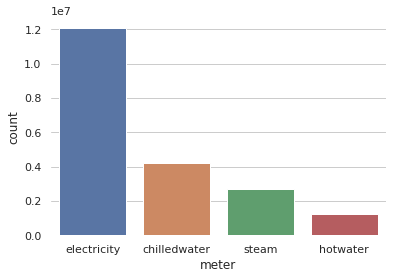

In [ ]:
plt.figure()

ax = sns.countplot(x='meter', data=train_df)
ax.set_xticklabels(meter_types_labels)

sns.despine(bottom=True, left=True) # get rid of useless infomation

The electricity meter generated the most of the reading data, followed by chilledwater and steam meter. The hotwater meter generated the least reading data.

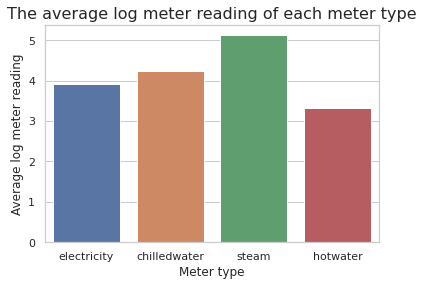

In [ ]:
fig, ax = plt.subplots()
meter_types = train_df.groupby('meter').meter_reading_log.mean().reset_index()
sns.barplot(x ='meter', y ='meter_reading_log', data = meter_types).set_title("The average log meter reading of each meter type", fontsize=16)
ax.set_xticklabels(meter_types_labels)
plt.xlabel('Meter type')
plt.ylabel('Average log meter reading')
plt.show()

Steam meters consume the most energy and hot Water meters consume the least energy.

In [ ]:
train_df['meter_count'] = 1
primary_use_df = train_df.groupby(['meter','timestamp']).sum()['meter_count'].reset_index()
fig = px.line(primary_use_df, x="timestamp", y="meter_count", color='meter', width=900, height=600, title = "Every meter's counting in every month")
fig.show()
train_df = train_df.drop(columns='meter_count')

**The meter type counting is not always the same.**
There is 1449 building total, but not every building have every meter record at any time.

## Other features' analysis

### Square feet

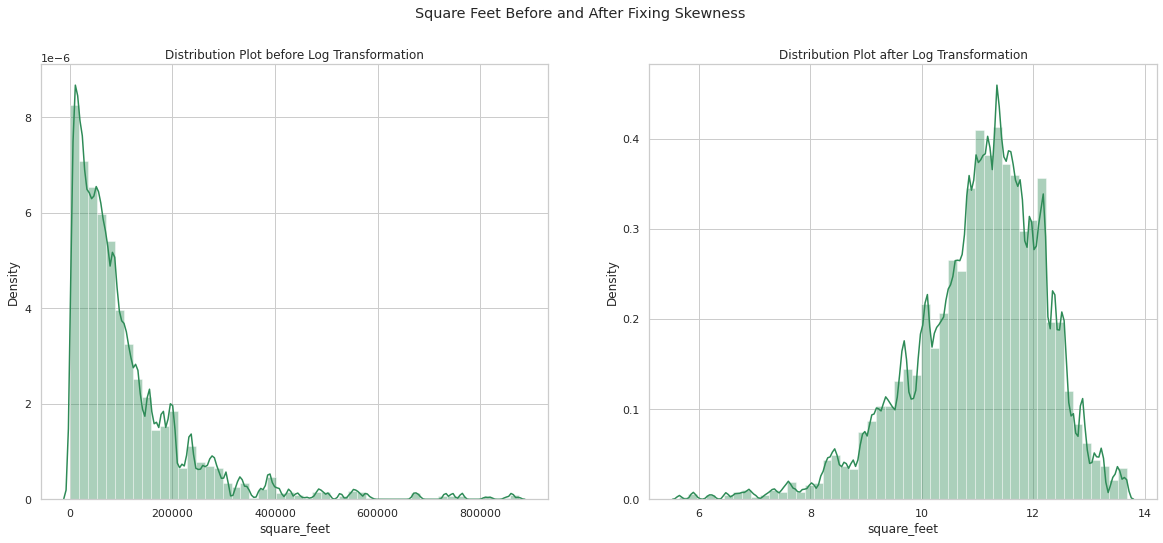

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Square Feet Before and After Fixing Skewness')

sns.distplot(train_df['square_feet'], color='seagreen', ax = ax1)
ax1.set_title('Distribution Plot before Log Transformation')

sns.distplot(np.log1p(train_df['square_feet']), color='seagreen', ax = ax2)
ax2.set_title('Distribution Plot after Log Transformation')

plt.show()

Square Feet is heavily skewed to the right, therefore, we apply log transformation to fix that.

In [ ]:
train_df['square_feet_log'] =  np.log1p(train_df['square_feet'])

### Floor count

In [ ]:
train_df['floor_count'].unique()
# there are 19 unique values

array([nan,  5.,  4., 10.,  6.,  8.,  7.,  9., 13., 16., 11., 12.,  2.,
        3.,  1., 14., 21., 26., 19.], dtype=float16)

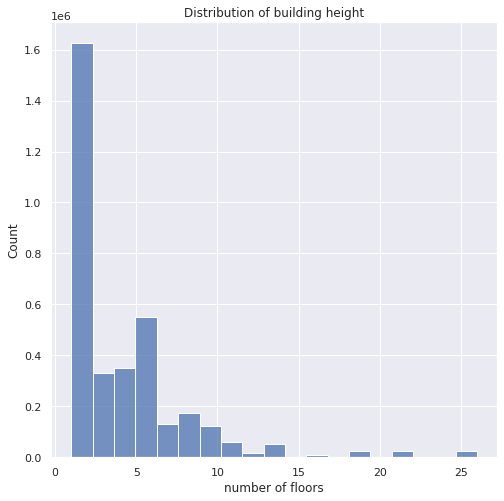

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
sns.histplot(train_df['floor_count'].dropna(), bins=19) # dropna, bin=19

plt.xlabel("number of floors")
plt.title("Distribution of building height")
plt.show()

Not much of the buildings have floors greater than 10. Most of buildings have floors less than 5.

### Year built

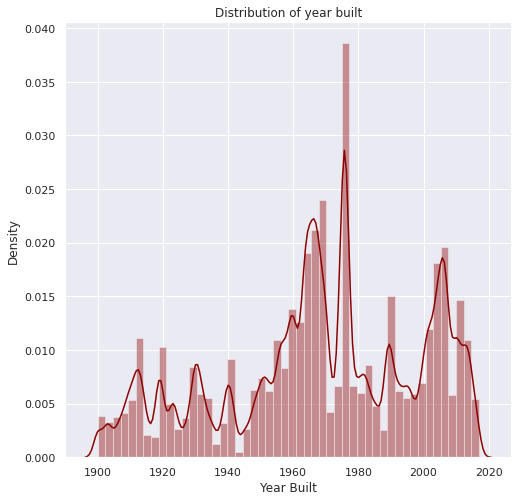

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['year_built'].dropna(), color='darkred')
plt.xlabel("Year Built")
plt.title("Distribution of year built")
plt.show()

The distribution is spread over a period about 120 years. Most of the buildings are built after 1960, peaked at around 1975.

### Air Temperature

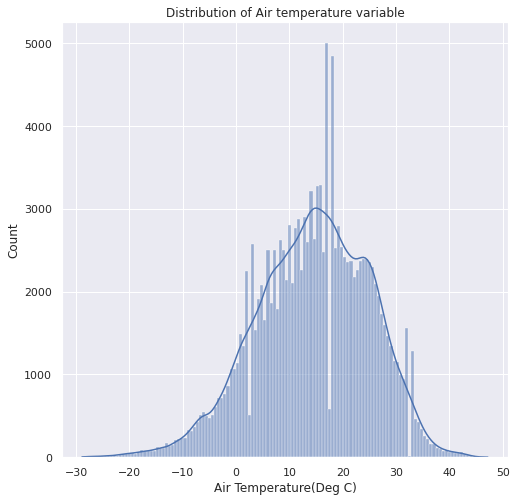

In [ ]:
plt.figure(figsize=(8,8))
sns.histplot(weather_train['air_temperature'].dropna(), kde=True)
plt.xlabel("Air Temperature(Deg C)")
plt.title("Distribution of Air temperature variable")
plt.show()

The air temperature roughly follows a normal distribution, which peak at around 14 deg C and the most of observations lie between -20-40 deg C.

### Dew temperature

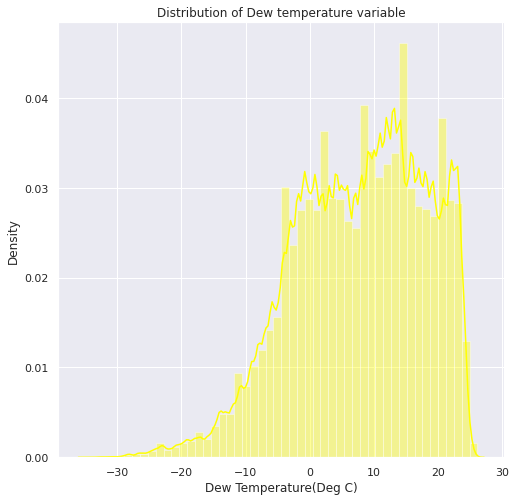

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['dew_temperature'].dropna(), color='yellow')
plt.xlabel("Dew Temperature(Deg C)")
plt.title("Distribution of Dew temperature variable")
plt.show()

The dew temperature is bit skewed towards left. The most of observations lie between -30-25 deg C

### Sea level pressure

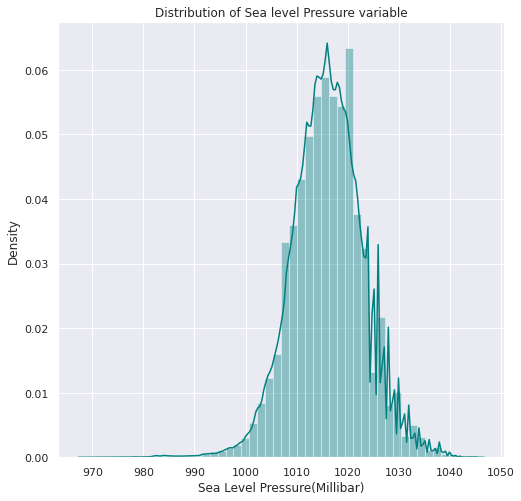

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['sea_level_pressure'].dropna(), color='teal')
plt.xlabel("Sea Level Pressure(Millibar)")
plt.title("Distribution of Sea level Pressure variable")
plt.show()

This follows a normal distribution with maximum of the observations lying between 1000 to 1030 millibar.

### Cloud coverage

Portion of the sky covered in clouds, for detils please click this link: https://en.wikipedia.org/wiki/Okta

In [ ]:
train_df['cloud_coverage'].unique()

array([ 6., nan,  8.,  4.,  0.,  2.,  7.,  5.,  3.,  9.,  1.],
      dtype=float16)

In [ ]:
okta = train_df['cloud_coverage'].dropna()
okta = okta.replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],['SKC(0)','FEW(1-2)','FEW(1-2)','SCT(3-4)','SCT(3-4)','BKN(5-7)','BKN(5-7)','BKN(5-7)','OVC(8)','OVC(8)']).reset_index()

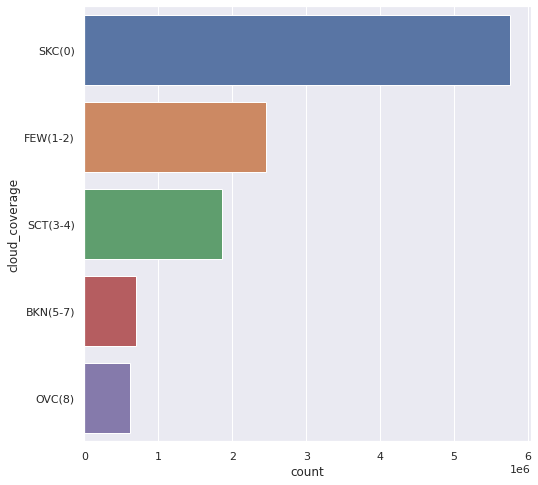

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='cloud_coverage', data=okta, order = okta['cloud_coverage'].value_counts().index)

Majority of the observations have cloud coverage as 0 (Sky clear). And with the cloud coverage increase the instance of it decrease.

In addition, there are lot of missing values in cloud coverage. We will impute them later.

### Windrose Rose Plot for 'wind_direction' and 'wind_speed'

In [ ]:
 !pip install windrose
 from windrose import WindroseAxes

In [ ]:
wind_df = train_df.loc[:,['wind_direction','wind_speed']].dropna()

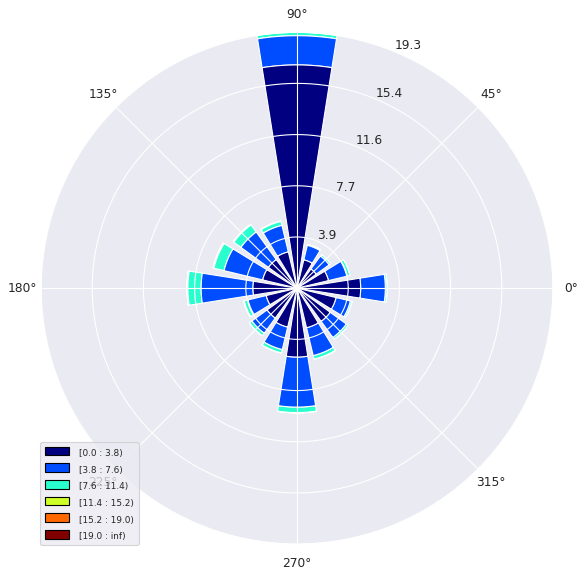

In [ ]:
ax = WindroseAxes.from_ax()
ax.bar(wind_df['wind_direction'], wind_df['wind_speed'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

The above windrose diagram shows that for most of the sites, the wind blows from East direction(90 degrees) most of the time, followed by West direction(270 degrees). Most of the wind speed is between 0 to 11.4 m/s from any direction.

## Correlation

In [ ]:
#correlation_matrix = train_df.corr()
'''plt.subplots(figsize = (24,16))
sns.heatmap(correlation_matrix,annot = True,vmax = 1,square = True,cmap = "Reds")
plt.show()'''

### Heatmap

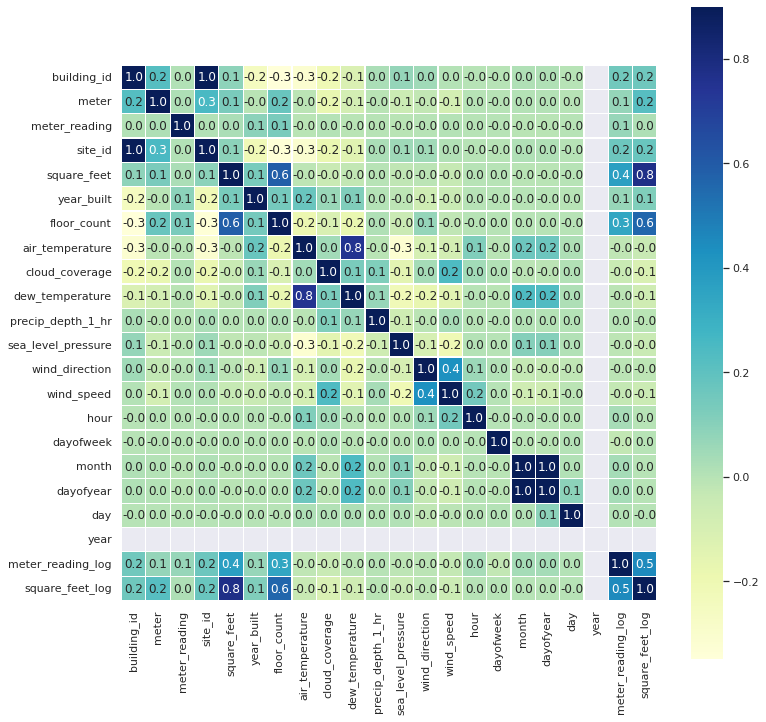

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(train_df.corr(), vmax=0.9, square=True, annot=True, linewidths=0.3, cmap="YlGnBu", fmt=".1f")

### 'floor_count' and 'square_feet'

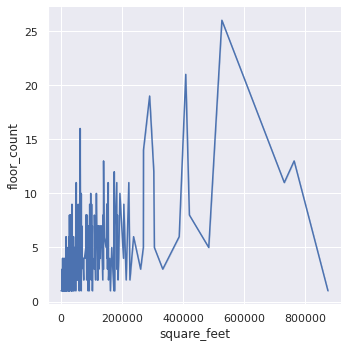

In [ ]:
sns.relplot(data=train_df, x='square_feet', y='floor_count', kind="line")

### 'dew_temperature' and 'air_temperature'

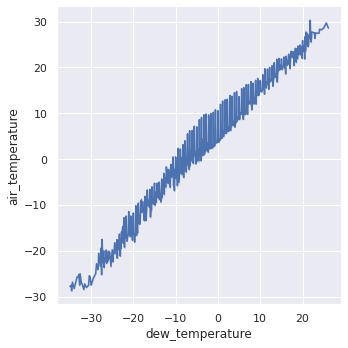

In [ ]:
sns.relplot(data=train_df, x='dew_temperature', y='air_temperature', kind="line")

There is strong positve correlation between dew_temperature and air_temperature.

###Average 'meter_reading_log' and 'air temperature'

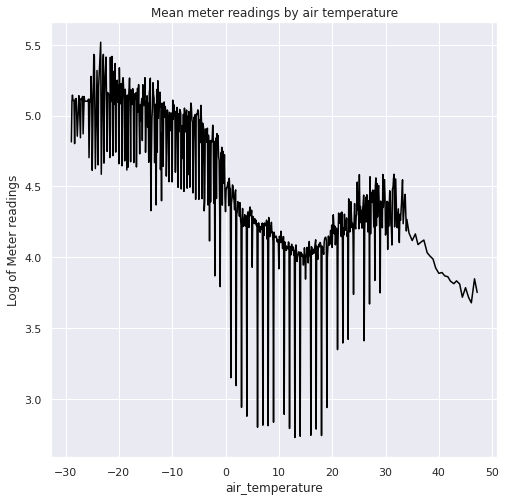

In [ ]:
plt.figure(figsize=(8,8))
temp_df= train_df.groupby('air_temperature').meter_reading_log.mean().reset_index()
sns.lineplot(x=temp_df['air_temperature'], y=temp_df['meter_reading_log'], color='black')
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by air temperature")
plt.show()

The average meter readings are high when the temperature is negative, once it starts increasing, the meter consumption reduces. It again increases when the temperature rises above 15 deg C.

###'meter_reading_log' and 'square_feet_log'

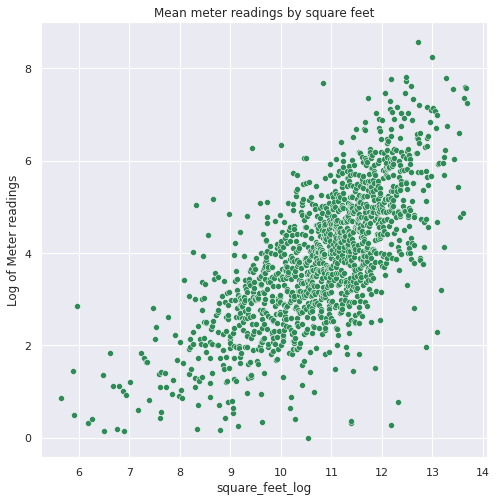

In [ ]:
plt.figure(figsize=(8,8))
feet_df= train_df.groupby('square_feet_log').meter_reading_log.mean().reset_index()
sns.scatterplot(x=feet_df['square_feet_log'], y=feet_df['meter_reading_log'], color='seagreen')
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by square feet")
plt.show()

After implement log transformation for both meter_reading and square_feet

There is clear positive relation between them. As the size of the building increases, the meter consumption also increases.

# T2 - Preprocessing

## Outlier treatment

In [ ]:
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
import scipy.stats as st

In [ ]:
num_col=['building_id','meter','meter_reading','square_feet','cloud_coverage','wind_direction','precip_depth_1_hr','sea_level_pressure','wind_speed', 'dew_temperature', 'air_temperature']

In [ ]:
out_per=[]
for i in num_col:
    data_mean, data_std = mean(train_df[i]), std(train_df[i])
# identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    print(i,': \n')
# identify outliers
    outliers = [x for x in train_df[i] if x < lower or x > upper]
    
    num_out=len(outliers)
    print('Identified outliers: %d' % num_out)
    outliers_removed = [x for x in train_df[i] if x >= lower and x <= upper]
    num_nout=len(outliers_removed)
    print('Non-outlier observations: %d' % num_nout)
    print('\n')

building_id : 

Identified outliers: 0
Non-outlier observations: 20216100


meter : 

Identified outliers: 0
Non-outlier observations: 20216100


meter_reading : 

Identified outliers: 3751
Non-outlier observations: 20212349


square_feet : 

Identified outliers: 445224
Non-outlier observations: 19770876


cloud_coverage : 

Identified outliers: 0
Non-outlier observations: 0


wind_direction : 

Identified outliers: 0
Non-outlier observations: 0


precip_depth_1_hr : 

Identified outliers: 0
Non-outlier observations: 0


sea_level_pressure : 

Identified outliers: 0
Non-outlier observations: 0


wind_speed : 

Identified outliers: 0
Non-outlier observations: 0


dew_temperature : 

Identified outliers: 0
Non-outlier observations: 0


air_temperature : 

Identified outliers: 0
Non-outlier observations: 0




### Check building outiler

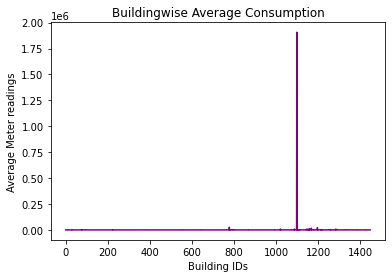

In [ ]:
plt.figure()
site_df= train_df.groupby(['building_id']).meter_reading.mean().reset_index()
sns.lineplot(x=site_df['building_id'], y=site_df['meter_reading'], color='purple')
plt.ylabel("Average Meter readings")
plt.xlabel("Building IDs")
plt.title("Buildingwise Average Consumption")
plt.show()

In [ ]:
train_df[train_df['building_id']==1099]['meter_reading'].describe()

count    1.756600e+04
mean     1.907326e+06
std      4.834750e+06
min      1.440000e+02
25%      5.203910e+02
50%      9.856970e+02
75%      7.008000e+03
max      2.190470e+07
Name: meter_reading, dtype: float64

In [ ]:
train_df[train_df.meter_reading == train_df.meter_reading.max()]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
8907488,1099,2,2016-06-13 09:00:00,21904700.0,13,Education,332884,NaN,NaN,19.40625,...,0.0,1014.5,50.0,6.199219,9,0,6,165,13,2016


In [ ]:
drop_indices= list(train_df[train_df['building_id']==1099].index)
train_df.drop(drop_indices, axis=0, inplace=True)

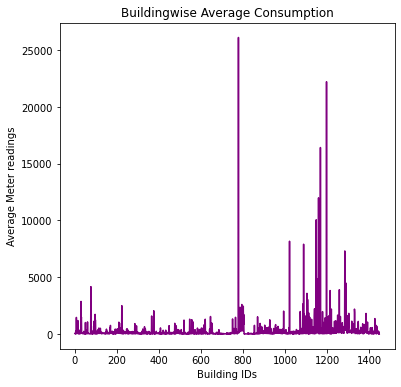

In [ ]:
# After drop building 1099, should we drop 778?
plt.figure(figsize = (6,6))
site_df= train_df.groupby(['building_id']).meter_reading.mean().reset_index()
sns.lineplot(x=site_df['building_id'], y=site_df['meter_reading'], color='purple')
plt.ylabel("Average Meter readings")
plt.xlabel("Building IDs")
plt.title("Buildingwise Average Consumption")
plt.show()

## Drop zero meter reading (for supervised learning models only)

In [ ]:
drop_0readings= list(train_df[train_df['meter_reading']==0.0].index)
train_df.drop(drop_0readings, axis=0, inplace=True)

In [ ]:
# dropped about 2M rows
train_df.shape

(18324558, 22)

## Missing value treatment

In [ ]:
percent_missing = (train_df.isnull().sum() * 100) / len(train_df)
missing_value_train_df = pd.DataFrame({'column_name': train_df.columns, 'percent_missing': percent_missing})
missing_value_train_df.sort_values(by='percent_missing', ascending= False)

,column_name,percent_missing
floor_count,floor_count,82.246055
year_built,year_built,60.117930
cloud_coverage,cloud_coverage,43.477960
precip_depth_1_hr,precip_depth_1_hr,19.219350
wind_direction,wind_direction,7.234532
sea_level_pressure,sea_level_pressure,6.480795
wind_speed,wind_speed,0.723472
dew_temperature,dew_temperature,0.505000
air_temperature,air_temperature,0.488110
day,day,0.000000


Based on missing values, remove floor_count and year_built as their missing values being above 50%

There is a pretty strong correlation between floor_count and square_feet so it may be best to drop floor_count and just use square_feet instead. As inputting 80% of values would not seem very robust……or could try both ways to see what works. --Owen

In [ ]:
#dropping: floor_count','year_built', comnsider dropping cloud_coverage
#meter_count should be dropped as well, it just a temp column to produce the count bar chart. --shang
# Yeah! Shang, I agree with it because meter_reading has a lot of inaccurate data.We should drop that column too -- Shashank

train_df = train_df.drop(['floor_count','year_built'], axis=1)
test_df = test_df.drop(['floor_count','year_built'], axis=1)
#train_df.head()

In [ ]:
percent_missing = (train_df.isnull().sum() * 100) / len(train_df)
missing_value_train_df = pd.DataFrame({'column_name': train_df.columns, 'percent_missing': percent_missing})
missing_value_train_df.sort_values(by='percent_missing', ascending= False)

,column_name,percent_missing
cloud_coverage,cloud_coverage,43.477960
precip_depth_1_hr,precip_depth_1_hr,19.219350
wind_direction,wind_direction,7.234532
sea_level_pressure,sea_level_pressure,6.480795
wind_speed,wind_speed,0.723472
dew_temperature,dew_temperature,0.505000
air_temperature,air_temperature,0.488110
day,day,0.000000
dayofyear,dayofyear,0.000000
month,month,0.000000


In [ ]:
train_df.isnull().sum()
#comment by Jinkai Zhang: in this cell we can check the 'wind_direction' which has 0 null value, as the output it seems unnecessary to add mean to fill the null.

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
air_temperature         89444
cloud_coverage        7967144
dew_temperature         92539
precip_depth_1_hr     3521861
sea_level_pressure    1187577
wind_direction        1325696
wind_speed             132573
hour                        0
dayofweek                   0
month                       0
dayofyear                   0
day                         0
year                        0
dtype: int64

## Adding some new features (for supervised learning models only)

In [ ]:
train_df['season'] = train_df['timestamp'].apply(lambda x: 'Spring' if x.month==3 or x.month==4 or x.month==5 else 
                                                  'Summer' if x.month==6 or x.month==7 or x.month==8 else 
                                                  'Autumn' if x.month==9 or x.month==10 or x.month==11 else 
                                                  'Winter')
test_df['season'] = test_df['timestamp'].apply(lambda x: 'Spring' if x.month==3 or x.month==4 or x.month==5 else 
                                                  'Summer' if x.month==6 or x.month==7 or x.month==8 else 
                                                  'Autumn' if x.month==9 or x.month==10 or x.month==11 else 
                                                  'Winter')
train_df['isDayTime'] = train_df['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)
test_df['isDayTime'] = test_df['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)

" \ntrain_df['season'] = train_df['timestamp'].apply(lambda x: 'Spring' if x.month==3 or x.month==4 or x.month==5 else \n                                                  'Summer' if x.month==6 or x.month==7 or x.month==8 else \n                                                  'Autumn' if x.month==9 or x.month==10 or x.month==11 else \n                                                  'Winter')\n\ntrain_df['isDayTime'] = train_df['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)\n"

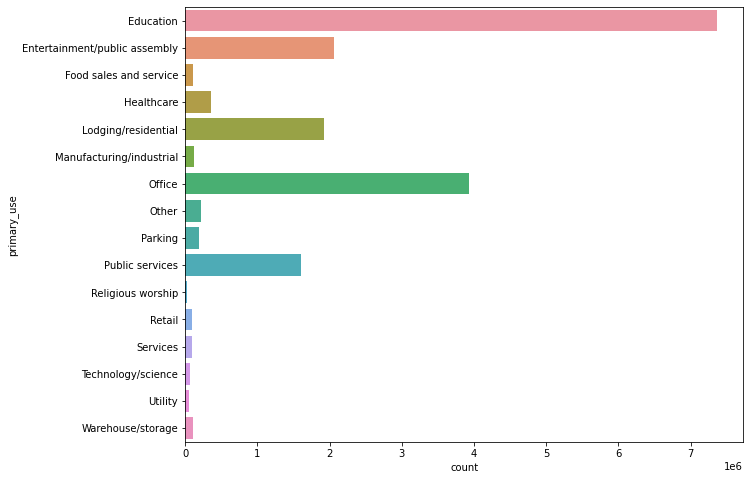

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.countplot(y='primary_use', data=train_df)

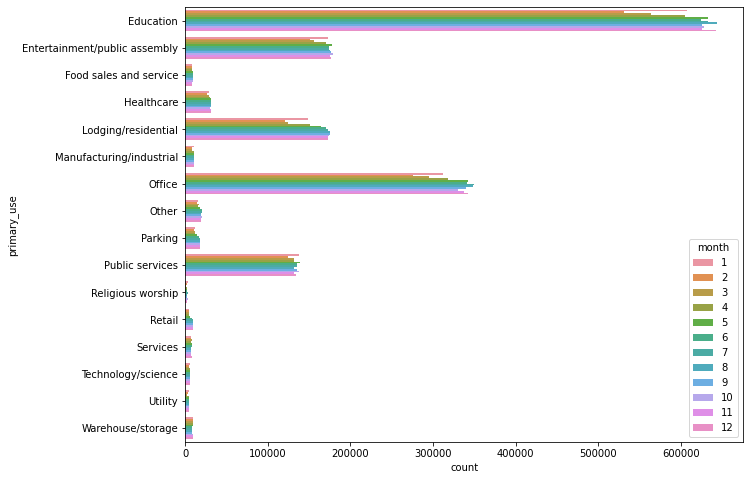

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.countplot(y='primary_use', data=train_df, hue= 'month')

In [ ]:
# train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,...,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,meter_reading_log,season,isDayTime
45,46,0,2016-01-01,15.604556,0,Retail,9045,25.000000,6.0,20.000000,...,0.0,0.000000,0,4,1,1,1,2.809677,Winter,0
72,74,0,2016-01-01,12.603682,0,Parking,387638,25.000000,6.0,20.000000,...,0.0,0.000000,0,4,1,1,1,2.610340,Winter,0
91,93,0,2016-01-01,15.364478,0,Office,33370,25.000000,6.0,20.000000,...,0.0,0.000000,0,4,1,1,1,2.795113,Winter,0
103,105,0,2016-01-01,23.303600,1,Education,50623,3.800781,NaN,2.400391,...,240.0,3.099609,0,4,1,1,1,3.190624,Winter,0
104,106,0,2016-01-01,0.374600,1,Education,5374,3.800781,NaN,2.400391,...,240.0,3.099609,0,4,1,1,1,0.318163,Winter,0


## **Preprocessing for Neural Networks**

In [ ]:
# Spliting the training data into two parts in order to run it using the available resources on colab pro
# All the variables ending in "1" correspond to first half of the data while those ending in "2" correspond to second half of the data

train_df1 = train_df[:int(train_df.shape[0] / 2)]
train_df2 = train_df[int(train_df.shape[0] / 2):]

In [ ]:
# Warning this code cell should only be run on Colab PRO since this requires RAM upto 25 GB
# The code below groups the data on 5 features and then aggregates the rest of the features required to implement the neural network
# The purpose is to categorise our data further so that meaningful insights can be gained during implementation

train_df1= train_df1.groupby(['meter',train_df1['building_id'],'primary_use',train_df1['month'], train_df1['day']]).agg({'meter_reading':'sum', 'air_temperature': 'mean', 'wind_speed': 'mean', 'precip_depth_1_hr': 'mean', 'cloud_coverage': 'mean', 'square_feet': 'mean'})

In [ ]:
train_df1

meter_reading  air_temperature  \
meter building_id primary_use       month day                                   
0     0           Education         1     1              0.0        23.343750   
                                          2              0.0        19.531250   
                                          3              0.0        14.828125   
                                          4              0.0        12.664062   
                                          5              0.0        14.062500   
...                                                      ...              ...   
3     1448        Warehouse/storage 7     27             0.0              NaN   
                                          28             0.0              NaN   
                                          29             0.0              NaN   
                                          30             0.0              NaN   
                                          31             0.0              NaN   

                                               wind_speed  precip_depth_1_hr  \
meter building_id primary_use       month day                                  
0     0           Education         1     1      1.854492          -0.173950   
                                          2      3.925781          -0.083313   
                                          3      5.000000           0.500000   
                                          4      4.285156           0.666504   
                                          5      6.257812           0.000000   
...                                                   ...                ...   
3     1448        Warehouse/storage 7     27          NaN                NaN   
                                          28          NaN                NaN   
                                          29          NaN                NaN   
                                          30          NaN                NaN   
                                          31          NaN                NaN   

                                               cloud_coverage  square_feet  
meter building_id primary_use       month day                               
0     0           Education         1     1          4.285156       7432.0  
                                          2          5.667969       7432.0  
                                          3          8.000000       7432.0  
                                          4          2.427734       7432.0  
                                          5          1.333008       7432.0  
...                                                       ...          ...  
3     1448        Warehouse/storage 7     27              NaN          NaN  
                                          28              NaN          NaN  
                                          29              NaN          NaN  
                                          30              NaN          NaN  
                                          31              NaN          NaN  

[20012608 rows x 6 columns]

In [ ]:
import gc
gc.collect()

88

In [ ]:
train_df2= train_df2.groupby(['meter',train_df2['building_id'],'primary_use',train_df2['month'], train_df2['day']]).agg({'meter_reading':'sum', 'air_temperature': 'mean', 'wind_speed': 'mean', 'precip_depth_1_hr': 'mean', 'cloud_coverage': 'mean', 'square_feet': 'mean'})

In [ ]:
train_df2

meter_reading  air_temperature  \
meter building_id primary_use       month day                                   
0     0           Education         7     1         0.000000              NaN   
                                          2         0.000000              NaN   
                                          3         0.000000              NaN   
                                          4       310.890594         33.62500   
                                          5      1382.403198         29.84375   
...                                                      ...              ...   
3     1448        Warehouse/storage 12    27        0.000000              NaN   
                                          28        0.000000              NaN   
                                          29        0.000000              NaN   
                                          30        0.000000              NaN   
                                          31        0.000000              NaN   

                                               wind_speed  precip_depth_1_hr  \
meter building_id primary_use       month day                                  
0     0           Education         7     1           NaN                NaN   
                                          2           NaN                NaN   
                                          3           NaN                NaN   
                                          4      2.916016           0.000000   
                                          5      2.537109          -0.041656   
...                                                   ...                ...   
3     1448        Warehouse/storage 12    27          NaN                NaN   
                                          28          NaN                NaN   
                                          29          NaN                NaN   
                                          30          NaN                NaN   
                                          31          NaN                NaN   

                                               cloud_coverage  square_feet  
meter building_id primary_use       month day                               
0     0           Education         7     1               NaN          NaN  
                                          2               NaN          NaN  
                                          3               NaN          NaN  
                                          4          6.000000       7432.0  
                                          5          4.800781       7432.0  
...                                                       ...          ...  
3     1448        Warehouse/storage 12    27              NaN          NaN  
                                          28              NaN          NaN  
                                          29              NaN          NaN  
                                          30              NaN          NaN  
                                          31              NaN          NaN  

[17213184 rows x 6 columns]

In [ ]:
train_df1 = train_df1.reset_index()
train_df2 = train_df2.reset_index()

In [ ]:
#Code below changes the type of the features to 'float32'

train_df1['wind_speed'] = train_df1['wind_speed'].astype('float32')
train_df1['air_temperature'] = train_df1['air_temperature'].astype('float32')
train_df1['precip_depth_1_hr'] = train_df1['precip_depth_1_hr'].astype('float32')

train_df2['wind_speed'] = train_df2['wind_speed'].astype('float32')
train_df2['air_temperature'] = train_df2['air_temperature'].astype('float32')
train_df2['precip_depth_1_hr'] = train_df2['precip_depth_1_hr'].astype('float32')

In [ ]:
# NaN Treatment

train_df1['wind_speed'].fillna(train_df1['wind_speed'].mean(), inplace=True)
train_df1['precip_depth_1_hr'].fillna(train_df1['precip_depth_1_hr'].mean(), inplace=True)
train_df1['air_temperature'].fillna(train_df1['air_temperature'].mean(), inplace=True)
train_df1['cloud_coverage'].fillna(train_df1['cloud_coverage'].median(), inplace=True)
train_df1['square_feet'].fillna(train_df1['square_feet'].median(), inplace=True)


train_df2['precip_depth_1_hr'].fillna(train_df2['precip_depth_1_hr'].mean(), inplace=True)
train_df2['wind_speed'].fillna(train_df2['wind_speed'].mean(), inplace=True)
train_df2['air_temperature'].fillna(train_df2['air_temperature'].mean(), inplace=True)
train_df2['cloud_coverage'].fillna(train_df2['cloud_coverage'].median(), inplace=True)
train_df2['square_feet'].fillna(train_df2['square_feet'].median(), inplace=True)

In [ ]:
train_df1.isnull().sum()

meter                0
building_id          0
primary_use          0
month                0
day                  0
meter_reading        0
air_temperature      0
wind_speed           0
precip_depth_1_hr    0
cloud_coverage       0
square_feet          0
dtype: int64

In [ ]:
train_df2.isnull().sum()

meter                0
building_id          0
primary_use          0
month                0
day                  0
meter_reading        0
air_temperature      0
wind_speed           0
precip_depth_1_hr    0
cloud_coverage       0
square_feet          0
dtype: int64

In [ ]:
train1_encoded = train_df1[:]
train2_encoded = train_df2[:]

In [ ]:
from sklearn.preprocessing import LabelEncoder

train1_encoded["primary_use"] = LabelEncoder().fit_transform(train1_encoded["primary_use"])

train2_encoded["primary_use"] = LabelEncoder().fit_transform(train2_encoded["primary_use"])

## **Preprocessing for Supervised Learning Models**


In [ ]:
#Alternative for filling data- unsure of the features used and the use of mean- discuss in meeting
def nan_fillers(df):
   air_temp_df=df.groupby(['site_id', 'day', 'month'])['air_temperature'].transform('mean')
   df['air_temperature'].fillna(air_temp_df, inplace=True)

   dew_temp_df=df.groupby(['site_id', 'day', 'month'])['dew_temperature'].transform('mean')
   df['dew_temperature'].fillna(dew_temp_df, inplace=True)

   #cloud_df=df.groupby(['site_id', 'day', 'month'])['cloud_coverage'].transform('median')
   #df['cloud_coverage'].fillna(cloud_df, inplace=True)

   #sea_level_df=df.groupby(['site_id', 'day', 'month'])['sea_level_pressure'].transform('median')
   #df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

   #precip_df=df.groupby(['site_id', 'day', 'month'])['precip_depth_1_hr'].transform('median')
   #
   #df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

   wind_dir_df=df.groupby(['site_id', 'day', 'month'])['wind_direction'].transform('mean')
   df['wind_direction'].fillna(wind_dir_df, inplace=True)

   wind_speed_df=df.groupby(['site_id', 'day', 'month'])['wind_speed'].transform('mean')
   df['wind_speed'].fillna(wind_speed_df, inplace=True)


   return df

train_df = nan_fillers(train_df) # this does not deal with the three features listed below
train_df['cloud_coverage'].fillna(train_df['cloud_coverage'].median(), inplace=True)
train_df['precip_depth_1_hr'].fillna(train_df['precip_depth_1_hr'].median(), inplace=True)
train_df['sea_level_pressure'].fillna(train_df['sea_level_pressure'].median(), inplace=True)
train_df.isnull().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
hour                  0
dayofweek             0
month                 0
dayofyear             0
day                   0
meter_reading_log     0
season                0
isDayTime             0
city                  0
country               0
dtype: int64

In [ ]:
test_df = nan_fillers(test_df) # this does not deal with the three features listed below
test_df['cloud_coverage'].fillna(test_df['cloud_coverage'].median(), inplace=True)
test_df['precip_depth_1_hr'].fillna(test_df['precip_depth_1_hr'].median(), inplace=True)
test_df['sea_level_pressure'].fillna(test_df['sea_level_pressure'].median(), inplace=True)
test.isnull().sum()

In [ ]:
# Encode categorical data
categorical_features = ['primary_use', 'season']
encoder = preprocessing.LabelEncoder()

for i in categorical_features:
  train[i] = encoder.fit_transform(train[i])
  test[i] = encoder.fit_transform(test[i])

In [ ]:
# Remove timestamp
train = train.drop(['timestamp'], axis = 1)
test = test.drop(['timestamp'], axis = 1)

In [ ]:
# Reduce memory usage (again)
reduced_train_data = reduce_mem_usage(train_df, 'Train Data')
reduced_test_data = reduce_mem_usage(test_df, 'Test Data')

In [ ]:
# Remove least important features generated by feature selection
train_data = reduced_train_data[['building_id','square_feet','meter','air_temperature','dayofyear','hour','isDayTime','dayofweek', 'meter_reading']]
test = reduced_test_data[['building_id','square_feet','meter','air_temperature','dayofyear','hour','isDayTime','dayofweek']]

# T3 - Implementation + Results

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.losses import MSE
from sklearn.model_selection  import train_test_split
from tensorflow.keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop,Adam
import keras.backend as K
import tensorflow as tf

In [ ]:
from sklearn import preprocessing
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras import regularizers
from tensorflow import keras

## **Gated Recurrent Unit (GRU) and Long Short Term Memory (LSTM)**

### **GRU**

In [ ]:
X1 = train1_encoded[['meter', 'building_id', 'primary_use', 'month', 'day','air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage',
       'square_feet']]
y1 = train1_encoded['meter_reading']

In [ ]:
X2 = train2_encoded[['meter', 'building_id', 'primary_use', 'month', 'day','air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage',
       'square_feet']]
y2 = train2_encoded['meter_reading']

In [ ]:
x_train1, x_val1, y_train1, y_val1 = train_test_split(X1,y1, test_size = 0.2, random_state= 45)

In [ ]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(X2,y2, test_size = 0.2, random_state= 45)

In [ ]:
from sklearn.metrics import mean_squared_log_error

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
# The following function reshapes the data and applies the log transormation to traget feature 'meter_reading' 
# since during T1 we were able to deduce that it was heavily skewed.

def transform(model,x_train,y_train,epochs=50,batch_size=500,verbose=1,validation_data=(x_val1,y_val1),callbacks =None):
  x_train = x_train.values[:]
  x_train= x_train.reshape((x_train.shape[0],1,x_train.shape[-1]))
  y_train = np.log1p(y_train) # log tran
  if validation_data != None:
    x_val = validation_data[0].values[:]
    x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[-1]))
    y_val = np.log1p(validation_data[-1]) # log tran
  #hist = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,validation_data=(x_val,y_val),callbacks=callbacks) 
  #model.save('gru.h5')   
  return model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,validation_data=(x_val,y_val),callbacks=callbacks)

In [ ]:
Early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.0001, patience=5, verbose=True, mode='auto')

In [ ]:
def model_gru(input_dim=10,metrics=root_mean_squared_error,loss='mse', optimizer="rmsprop",drop_rate=0.2):

  model = Sequential()
  model.add(GRU(128,return_sequences=True, input_shape=(None,input_dim)))
  model.add(Dropout(drop_rate))
  model.add(BatchNormalization())
  model.add(GRU(128,return_sequences=False))
  model.add(BatchNormalization())
  model.add(Dropout(drop_rate))
  model.add(Dense(1))
  model.compile(optimizer=optimizer, loss=loss, metrics=[metrics, 'accuracy'])
  
  return model

In [ ]:
GRU_model1 = model_gru(input_dim=x_train1.shape[-1],drop_rate=0.2)
GRU_model2 = model_gru(input_dim=x_train2.shape[-1],drop_rate=0.2)

In [ ]:
import gc
gc.collect()

88

In [ ]:
GRU_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 128)         53760     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [ ]:
history1 = transform(GRU_model1,x_train1,y_train1,epochs=30,batch_size=500,verbose=1,validation_data=(x_val1,y_val1), callbacks =[Early_stop])

Epoch 1/30
32021/32021 [==============================] - 828s 26ms/step - loss: 1.1694 - root_mean_squared_error: 1.0643 - accuracy: 0.9780 - val_loss: 1.1826 - val_root_mean_squared_error: 1.0712 - val_accuracy: 0.9805
Epoch 2/30
32021/32021 [==============================] - 901s 28ms/step - loss: 1.1760 - root_mean_squared_error: 1.0676 - accuracy: 0.9802 - val_loss: 1.1744 - val_root_mean_squared_error: 1.0666 - val_accuracy: 0.9805
Epoch 3/30
32021/32021 [==============================] - 778s 24ms/step - loss: 1.1764 - root_mean_squared_error: 1.0679 - accuracy: 0.9805 - val_loss: 1.1743 - val_root_mean_squared_error: 1.0664 - val_accuracy: 0.9805
Epoch 4/30
32021/32021 [==============================] - 702s 22ms/step - loss: 1.1764 - root_mean_squared_error: 1.0675 - accuracy: 0.9805 - val_loss: 1.1743 - val_root_mean_squared_error: 1.0664 - val_accuracy: 0.9805
Epoch 5/30
32021/32021 [==============================] - 741s 23ms/step - loss: 1.1764 - root_mean_squared_error: 1

In [ ]:
loss1 = history1.history
loss1.keys()

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])

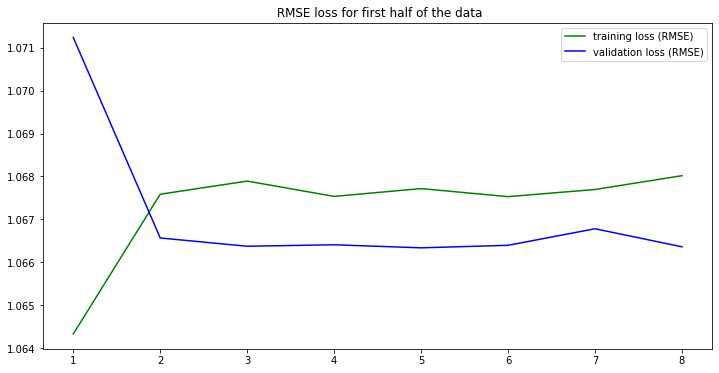

In [ ]:
rmse_loss_train1 = loss1['root_mean_squared_error']
rmse_loss_val1 = loss1['val_root_mean_squared_error']
epochs_stops = Early_stop.stopped_epoch +1 # epochs number from early stopping
epochs = range(1,epochs_stops + 1)  #len(loss_train)
plt.figure(figsize=(12,6))
plt.plot(epochs,rmse_loss_train1,'g', label='training loss (RMSE)')
plt.plot(epochs,rmse_loss_val1,'b',label='validation loss (RMSE)')
plt.title(' RMSE loss for first half of the data')
plt.legend()
plt.show()

In [ ]:
history2 = transform(GRU_model2,x_train2,y_train2,epochs=30,batch_size=500,verbose=1,validation_data=(x_val2,y_val2), callbacks =[Early_stop])

Epoch 1/30
27542/27542 [==============================] - 607s 22ms/step - loss: 1.4167 - root_mean_squared_error: 1.1751 - accuracy: 0.9729 - val_loss: 1.4202 - val_root_mean_squared_error: 1.1771 - val_accuracy: 0.9766
Epoch 2/30
27542/27542 [==============================] - 593s 22ms/step - loss: 1.4243 - root_mean_squared_error: 1.1784 - accuracy: 0.9764 - val_loss: 1.4188 - val_root_mean_squared_error: 1.1763 - val_accuracy: 0.9766
Epoch 3/30
27542/27542 [==============================] - 590s 21ms/step - loss: 1.4262 - root_mean_squared_error: 1.1794 - accuracy: 0.9765 - val_loss: 1.4186 - val_root_mean_squared_error: 1.1763 - val_accuracy: 0.9766
Epoch 4/30
27542/27542 [==============================] - 613s 22ms/step - loss: 1.4262 - root_mean_squared_error: 1.1793 - accuracy: 0.9765 - val_loss: 1.4197 - val_root_mean_squared_error: 1.1766 - val_accuracy: 0.9766
Epoch 5/30
27542/27542 [==============================] - 634s 23ms/step - loss: 1.4262 - root_mean_squared_error: 1

In [ ]:
loss2 = history2.history
loss2.keys()

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])

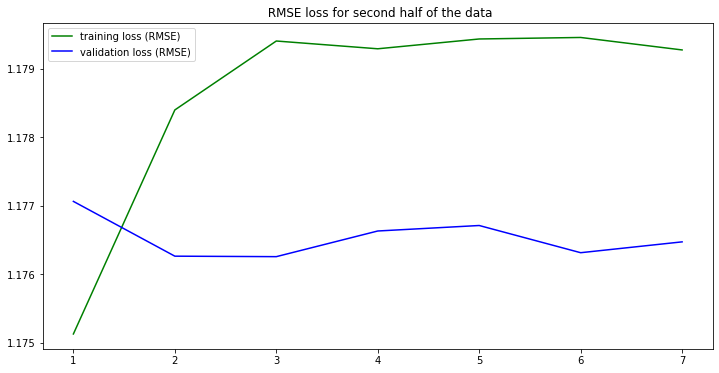

In [ ]:
rmse_loss_train2 = loss2['root_mean_squared_error']
rmse_loss_val2 = loss2['val_root_mean_squared_error']
epochs_stops = Early_stop.stopped_epoch +1 # epochs number from early stopping
epochs = range(1,epochs_stops + 1)  #len(loss_train)
plt.figure(figsize=(12,6))
plt.plot(epochs,rmse_loss_train2,'g', label='training loss (RMSE)')
plt.plot(epochs,rmse_loss_val2,'b',label='validation loss (RMSE)')
plt.title(' RMSE loss for second half of the data')
plt.legend()
plt.show()

### **LSTM**

In [ ]:
def model_lstm(input_dim=10,metrics=root_mean_squared_error,loss='mse', optimizer="rmsprop",drop_rate=0.2):

  model = Sequential()
  model.add(LSTM(128,return_sequences=True, input_shape=(None,input_dim)))
  model.add(Dropout(drop_rate))
  model.add(BatchNormalization())
  model.add(LSTM(128,return_sequences=False))
  model.add(BatchNormalization())
  model.add(Dropout(drop_rate))
  model.add(Dense(1))
  model.compile(optimizer=optimizer, loss=loss, metrics=[metrics, 'accuracy'])
  
  return model

In [ ]:
LSTM_model1 = model_lstm(input_dim=x_train1.shape[-1],drop_rate=0.2)
LSTM_model2 = model_lstm(input_dim=x_train2.shape[-1],drop_rate=0.2)

In [ ]:
LSTM_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         71168     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [ ]:
history1 = transform(LSTM_model1,x_train1,y_train1,epochs=30,batch_size=500,verbose=1,validation_data=(x_val1,y_val1), callbacks =[Early_stop])

Epoch 1/30
32021/32021 [==============================] - 789s 24ms/step - loss: 1.1719 - root_mean_squared_error: 1.0659 - accuracy: 0.9787 - val_loss: 1.1739 - val_root_mean_squared_error: 1.0662 - val_accuracy: 0.9805
Epoch 2/30
32021/32021 [==============================] - 813s 25ms/step - loss: 1.1746 - root_mean_squared_error: 1.0670 - accuracy: 0.9805 - val_loss: 1.1743 - val_root_mean_squared_error: 1.0666 - val_accuracy: 0.9805
Epoch 3/30
32021/32021 [==============================] - 879s 27ms/step - loss: 1.1706 - root_mean_squared_error: 1.0649 - accuracy: 0.9802 - val_loss: 1.1740 - val_root_mean_squared_error: 1.0661 - val_accuracy: 0.9805
Epoch 4/30
32021/32021 [==============================] - 908s 28ms/step - loss: 1.1751 - root_mean_squared_error: 1.0670 - accuracy: 0.9805 - val_loss: 1.0978 - val_root_mean_squared_error: 1.0295 - val_accuracy: 0.9804
Epoch 5/30
32021/32021 [==============================] - 854s 27ms/step - loss: 1.1764 - root_mean_squared_error: 1

In [ ]:
loss1 = history1.history
loss1.keys()

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])

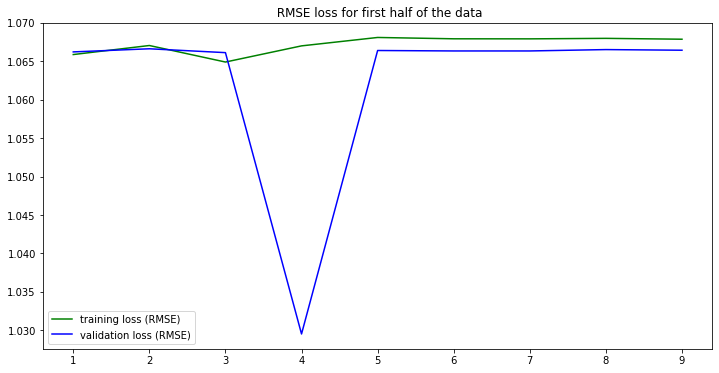

In [ ]:
rmse_loss_train1 = loss1['root_mean_squared_error']
rmse_loss_val1 = loss1['val_root_mean_squared_error']
epochs_stops = Early_stop.stopped_epoch + 1 # epochs number from early stopping
epochs = range(1,epochs_stops + 1)  #len(loss_train)
plt.figure(figsize=(12,6))
plt.plot(epochs,rmse_loss_train1,'g', label='training loss (RMSE)')
plt.plot(epochs,rmse_loss_val1,'b',label='validation loss (RMSE)')
plt.title(' RMSE loss for first half of the data')
plt.legend()
plt.show()

In [ ]:
history2 = transform(LSTM_model2,x_train2,y_train2,epochs=30,batch_size=500,verbose=1,validation_data=(x_val2,y_val2), callbacks =[Early_stop])

Epoch 1/30
27542/27542 [==============================] - 846s 31ms/step - loss: 1.4215 - root_mean_squared_error: 1.1771 - accuracy: 0.9739 - val_loss: 1.4185 - val_root_mean_squared_error: 1.1762 - val_accuracy: 0.9766
Epoch 2/30
27542/27542 [==============================] - 769s 28ms/step - loss: 1.4253 - root_mean_squared_error: 1.1788 - accuracy: 0.9765 - val_loss: 1.4191 - val_root_mean_squared_error: 1.1765 - val_accuracy: 0.9766
Epoch 3/30
27542/27542 [==============================] - 777s 28ms/step - loss: 1.4267 - root_mean_squared_error: 1.1797 - accuracy: 0.9765 - val_loss: 1.4191 - val_root_mean_squared_error: 1.1765 - val_accuracy: 0.9766
Epoch 4/30
27542/27542 [==============================] - 813s 30ms/step - loss: 1.4267 - root_mean_squared_error: 1.1797 - accuracy: 0.9765 - val_loss: 1.4191 - val_root_mean_squared_error: 1.1765 - val_accuracy: 0.9766
Epoch 5/30
27542/27542 [==============================] - 831s 30ms/step - loss: 1.4261 - root_mean_squared_error: 1

In [ ]:
loss2 = history2.history
loss2.keys()

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])

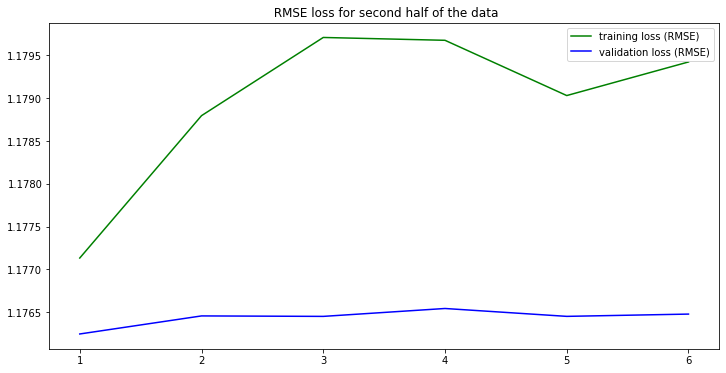

In [ ]:
rmse_loss_train2 = loss2['root_mean_squared_error']
rmse_loss_val2 = loss2['val_root_mean_squared_error']
epochs_stops = Early_stop.stopped_epoch +1 # epochs number from early stopping
epochs = range(1,epochs_stops + 1)  #len(loss_train)
plt.figure(figsize=(12,6))
plt.plot(epochs,rmse_loss_train2,'g', label='training loss (RMSE)')
plt.plot(epochs,rmse_loss_val2,'b',label='validation loss (RMSE)')
plt.title(' RMSE loss for second half of the data')
plt.legend()
plt.show()

## 10% regression models

In [ ]:
test

,index,building_id,square_feet,meter,air_temperature,dayofyear,hour,isDayTime,dayofweek
0,0,0,8.914062,0,17.796875,1.0,0.0,0,6.0
1,1,1,7.910156,0,17.796875,1.0,0.0,0,6.0
2,2,2,8.593750,0,17.796875,1.0,0.0,0,6.0
3,3,3,10.070312,0,17.796875,1.0,0.0,0,6.0
4,4,4,11.664062,0,17.796875,1.0,0.0,0,6.0
...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,9.882812,0,12.031250,129.0,7.0,1,2.0
41697596,41697596,1445,8.367188,0,12.031250,129.0,7.0,1,2.0
41697597,41697597,1446,9.328125,0,12.031250,129.0,7.0,1,2.0
41697598,41697598,1447,10.304688,0,12.031250,129.0,7.0,1,2.0


In [ ]:
tenPercenteTrain = train_data[0:10000000]

In [ ]:
X = tenPercenteTrain[['index','building_id', 
       'square_feet','meter', 'air_temperature',
         'dayofyear','hour', 'isDayTime','dayofweek']]
y = tenPercenteTrain['meter_reading']

In [ ]:
from sklearn.model_selection  import train_test_split
from sklearn.pipeline import Pipeline

x_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state= 45)

## Feature Selection - Univariate Selection

In [ ]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
array = halfTrain_df_int.values
# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X, y)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_.tolist())
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

[5.746127707344802, 18.347876347811017, 6.194578278513344, 28.394353699479087, 6.8630224866879335, 1.1601389145602758, 5.668209131360699, 1.8271230556878795, 1.578893107689737, 1.7690336254214167, 1.0912002508824097, 1.30058837996384, 1.4045061502792229, 1.4045061502792229, 1.2162837388064622]
[[     0      0   9045     25]
 [     0      0 387638     25]
 [     0      0  33370     25]
 [     0      1  50623      3]
 [     0      1   5374      3]]


## KNN Implementation

### KNN Hyperparameter

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

test_accuracy=[]
n_estimator = range(10,50,10)
clock = 0
for n in n_estimator:
  clock = clock+1
  KNN_test = Pipeline(
      [('preprocessing',preprocessor),
       ('classifier', KNeighborsClassifier(n_neighbors= n))
       ]   
  )
  KNN_test.fit(x_train, y_train)
  print(clock)
  y_hat = KNN_test.predict(x_val)
  test_accuracy.append(accuracy_score(y_val,y_hat))
index_n = test_accuracy.index(max(test_accuracy))
optimum_n = n_estimator[index_n]
optimum_n
#optimum_n = 10

1


10

### KNN Regression Model

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
KNN_clf = Pipeline(
    [
     ('classifier', KNeighborsRegressor(n_neighbors=10))
    ]
)
KNN_clf.fit(x_train, y_train)


Pipeline(steps=[('classifier', KNeighborsRegressor(n_neighbors=10))])

### Prediction

In [ ]:
knnPred = []

In [ ]:
steps = np.arange(0,len(test),10000)


In [ ]:
for i in steps:
  test_samp = test[i:i+10000]
  knnPred.append(KNN_clf.predict(test_samp))

In [ ]:
knnPredArray = np.concatenate((knnPred),axis=0)

In [ ]:
KNN_preddf = pd.DataFrame(knnPredArray, columns = ["meter_reading"])
KNN_preddf.insert(0, "row_id",test["index"])

In [ ]:
KNN_preddf = KNN_preddf.astype({'row_id':'int32'})
KNN_preddf = KNN_preddf.astype({'meter_reading':'float32'})

In [ ]:
KNN_preddf

,row_id,meter_reading
0,0,3.750000
1,1,3.750000
2,2,3.750000
3,3,3.750000
4,4,3.750000
...,...,...
41697595,41697595,2.421875
41697596,41697596,2.421875
41697597,41697597,2.421875
41697598,41697598,2.421875


Kaggle Score =  3.416

## Decision Tree Classifier

### DTree Hyperparameter

In [ ]:
from sklearn.tree import DecisionTreeClassifier

test_accuracy=[]
n_estimator = range(80,150,10)

for n in n_estimator:
  tree_clf = Pipeline(
      [('preprocessing',preprocessor),
       ('classifier', DecisionTreeClassifier(max_depth=n, random_state=10))
       ]   
  )
  tree_clf.fit(x_train, y_train)
  y_hat = tree_clf.predict(x_val)
  test_accuracy.append(accuracy_score(y_val,y_hat))
index_n = test_accuracy.index(max(test_accuracy))
optimum_n = n_estimator[index_n]
optimum_n
#max_depth = 14 random_state = 10 optimal is 110 but this is not reasonable within the software limitations

110

### Decision Regression Model

In [ ]:
from sklearn.tree import DecisionTreeRegressor
#start_time = time.time()
tree_clf = Pipeline(
    [
     ('classifier', DecisionTreeRegressor(max_depth=14, random_state=10))
    ]
)

tree_clf.fit(x_train, y_train)
#print(" %s seconds " % (time.time() - start_time))
#Eager Learner

Pipeline(steps=[('classifier',
                 DecisionTreeRegressor(max_depth=14, random_state=10))])

### prediction

In [ ]:
tree_pred = tree_clf.predict(test)

In [ ]:
arrayToList = tree_pred.tolist()

In [ ]:
tree_pred_df = pd.DataFrame()  

In [ ]:
tree_pred_df['meter_reading'] = arrayToList
tree_pred_df.insert(0, "row_id",test["index"])

In [ ]:
tree_pred_df = tree_pred_df.astype({'row_id':'int32'})
tree_pred_df = tree_pred_df.astype({'meter_reading':'float32'})

Kaggle Score = 3.021